## 利用Python实现报表自动化

In [1]:
import pandas as pd
from datetime import datetime
data = pd.read_csv(r"../Data/order-14.1.csv", sep=",",engine = "python",encoding="gbk",parse_dates=["成交时间"])
data.head()
data.info()
this_month = data[(data["成交时间"]>= datetime(2018,2,1)) & (data["成交时间"]<= datetime(2018,2,28))]
last_month = data[(data["成交时间"]>= datetime(2018,1,1)) & (data["成交时间"]<= datetime(2018,1,31))]
same_month = data[(data["成交时间"]>= datetime(2017,2,1)) & (data["成交时间"]<= datetime(2017,2,28))]

def get_month_data(data):
    sale = (data["单价"]*data["销量"]).sum()
    traffic = data["订单ID"].drop_duplicates().count()
    s_t = sale/traffic
    return (sale,traffic,s_t)
sale_1,traffic_1,s_t_1 = get_month_data(this_month)
sale_2,traffic_2,s_t_2 = get_month_data(last_month)
sale_3,traffic_3,s_t_3 = get_month_data(same_month)

report = pd.DataFrame([[sale_1,sale_2,sale_3],
                       [traffic_1,traffic_2,traffic_3],
                       [s_t_1,s_t_2,s_t_3]],
                     columns = ["本月累计","上月同期","去年同期"],
                     index =["销售额","客流量","客单价"])
report

#添加同比和环比字段
report["环比"] = report["本月累计"]/report["上月同期"] -1
report["同比"] = report["本月累计"]/report["去年同期"] -1
report
report.to_csv(r"../Data/order.csv",encoding = "utf-8-sig")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3744 entries, 0 to 3743
Data columns (total 7 columns):
商品ID    3478 non-null float64
类别ID    3478 non-null float64
门店编号    3478 non-null object
单价      3478 non-null float64
销量      3478 non-null float64
成交时间    3478 non-null datetime64[ns]
订单ID    3478 non-null object
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 204.8+ KB


## 自动发送电子邮件

In [1]:
from email.mime.multipart import MIMEMultipart
import smtplib
from email import encoders
from email.header import Header
from email.mime.text import MIMEText
from email.utils import parseaddr,formataddr
from email.mime.application import MIMEApplication

#发件人邮箱
asender = ""

#收件人邮箱
areceiver = ""

#抄送人邮箱
acc = ""

#邮件主题
asubject = "这是一份测试邮件"

#发件人地址
from_addr = ""

#邮箱密码（授权码）
password = ""

#邮件设置
msg = MIMEMultipart()
msg["Subject"] = asubject
msg["to"] = areceiver
msg["Cc"] = acc
msg["from"] = asender

#邮件正文
body = "你好，这是一封测试邮件"

#添加邮件正文
msg.attach(MIMEText(body,'plain','utf-8'))

#添加附件
#注意，这里的文件路径是分割线
filename = "测试文档.xlsx"
xlsxpart = MIMEApplication(open(r'C:/Users/Administrator/Excel-Python/Data/测试文档.xlsx','rb').read())
xlsxpart.add_header('Content-Disposition', 'attachment',filename="测试文档.xlsx") 
msg.attach(xlsxpart)


#设置邮箱服务器地址及端口
smtp_server= "smtp.qq.com"
server = smtplib.SMTP(smtp_server,25)
#打印日志
server.set_debuglevel(1)

#登录邮箱
server.login(from_addr,password)
server.sendmail(from_addr,areceiver.split(",")+acc.split(","),msg.as_string())

#断开服务器连接
server.quit()

(221, b'Bye')

## 超市数据分析

In [18]:
import pandas as pd
from datetime import datetime
data = pd.read_csv(r"../Data/order-14.3.csv", sep=",",engine = "python",encoding="gbk",parse_dates=["成交时间"])
data.head()

,商品ID,类别ID,门店编号,单价,销量,成交时间,订单ID
0,30006206,915000003,CDNL,25.23,0.328,2017-01-03 09:56:00,20170103CDLG000210052759
1,30163281,914010000,CDNL,2.00,2.000,2017-01-03 09:56:00,20170103CDLG000210052759
2,30200518,922000000,CDNL,19.62,0.230,2017-01-03 09:56:00,20170103CDLG000210052759
3,29989105,922000000,CDNL,2.80,2.044,2017-01-03 09:56:00,20170103CDLG000210052759
4,30179558,915000100,CDNL,47.41,0.226,2017-01-03 09:56:00,20170103CDLG000210052759


- **看那些列别的商品比较热销**

In [19]:
data.groupby("类别ID")["销量"].sum().reset_index().sort_values(by="销量",ascending = False).head(10)

,类别ID,销量
240,922000003,425.328
239,922000002,206.424
251,923000006,190.294
216,915030104,175.059
238,922000001,121.355
367,960000000,121.000
234,920090000,111.565
249,923000002,91.847
237,922000000,86.395
247,923000000,85.845


- **看那些商品比较畅销**

In [20]:
pd.pivot_table(data,index="商品ID",values ="销量",aggfunc = "sum").reset_index().sort_values(by="销量",ascending = False).head(10)

,商品ID,销量
8,29989059,391.549
18,29989072,102.876
469,30022232,101.000
523,30031960,99.998
57,29989157,72.453
476,30023041,64.416
505,30026255,62.375
7,29989058,56.052
510,30027007,48.757
903,30171264,45.000


- **不同门店的销售额占比**

In [21]:
data["销售额"] = data["销量"]*data["单价"]
data.groupby("门店编号")["销售额"].sum()

门店编号
CDLG    10908.82612
CDNL     8059.47867
CDXL     9981.76166
Name: 销售额, dtype: float64

In [22]:
data.groupby("门店编号")["销售额"].sum()/data["销售额"].sum()

门店编号
CDLG    0.376815
CDNL    0.278392
CDXL    0.344792
Name: 销售额, dtype: float64

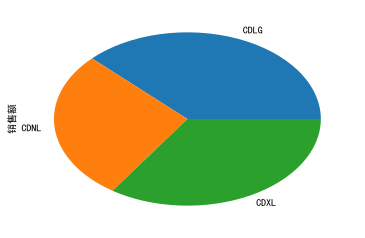

In [8]:
#绘制饼图
#导入matplotlib库中的pyplot并起名为plt
import matplotlib.pyplot as plt
#让画布直接在jupyter Notebook中展示出来
%matplotlib inline
#解决中文乱码问题
plt.rcParams["font.sans-serif"]='SimHei'
#解决负号无法正常显示问题
plt.rcParams["axes.unicode_minus"]= False
#设置为矢量图
%config InlineBackend.figure_format = 'svg'
#建立画布
fig = plt.figure()
(data.groupby("门店编号")["销售额"].sum()/data["销售额"].sum()).plot.pie()

- **那些时段是超市客流高峰**

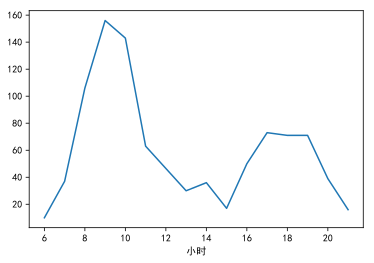

In [23]:
#提取小时数
data["小时"] = data["成交时间"].map(lambda x:int(x.strftime("%H")))
#对小时和订单去重
tracffic = data[["小时","订单ID"]].drop_duplicates()
#求每个小时的客流量
tracffic.groupby("小时")["订单ID"].count()
#绘制折线图
tracffic.groupby("小时")["订单ID"].count().plot()

## 银行数据分析

In [10]:
import pandas as pd
from datetime import datetime
data = pd.read_csv(r"../Data/loan.csv", sep=",",engine = "python",encoding="gbk")
data.info()
data.head()
#处理月收入缺失值的数据
data = data.fillna({"月收入":data["月收入"].mean()})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 6 columns):
用户ID    150000 non-null int64
好坏客户    150000 non-null int64
年龄      150000 non-null int64
负债率     150000 non-null float64
月收入     120269 non-null float64
家属数量    146076 non-null float64
dtypes: float64(3), int64(3)
memory usage: 6.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 6 columns):
用户ID    150000 non-null int64
好坏客户    150000 non-null int64
年龄      150000 non-null int64
负债率     150000 non-null float64
月收入     150000 non-null float64
家属数量    146076 non-null float64
dtypes: float64(3), int64(3)
memory usage: 6.9 MB


- **收入和坏账率的关系**

In [11]:
#区间切分
cut_bins = [0,5000,10000,15000,20000,100000]
income_cut = pd.cut(data["月收入"],cut_bins)
income_cut
all_income_user = data["好坏客户"].groupby(income_cut).count()
bad_income_user = data["好坏客户"].groupby(income_cut).sum()
bad_rate = bad_income_user/all_income_user
bad_rate

月收入
(0, 5000]          0.087543
(5000, 10000]      0.058308
(10000, 15000]     0.041964
(15000, 20000]     0.041811
(20000, 100000]    0.053615
Name: 好坏客户, dtype: float64

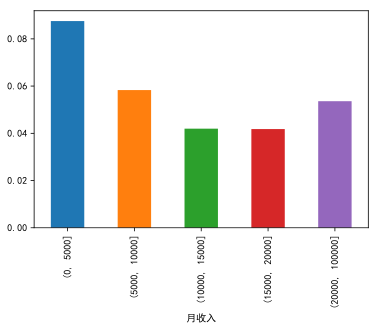

In [12]:
#绘制图形
bad_rate.plot.bar()

- **年龄和坏账率关系**

In [13]:
data = pd.read_csv(r"../Data/loan.csv", sep=",",engine = "python",encoding="gbk")
age_cut = pd.qcut(data["年龄"],6)
all_age_user = data["好坏客户"].groupby(age_cut).count()
bad_age_user = data["好坏客户"].groupby(age_cut).sum()
bad_rate = bad_age_user/all_age_user
bad_rate

年龄
(-0.001, 37.0]    0.108201
(37.0, 45.0]      0.086841
(45.0, 52.0]      0.078956
(52.0, 59.0]      0.059600
(59.0, 67.0]      0.039205
(67.0, 109.0]     0.022498
Name: 好坏客户, dtype: float64

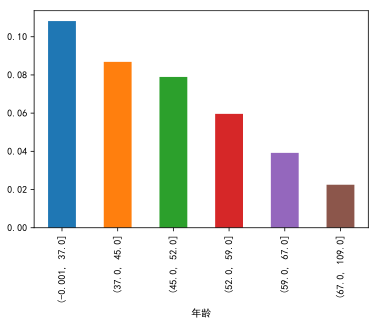

In [14]:
#绘制图形
bad_rate.plot.bar()

- **家庭人口数量和坏账率关系**

In [15]:
all_age_user = data.groupby("家属数量")["好坏客户"].count()
bad_age_user = data.groupby("家属数量")["好坏客户"].sum()
bad_rate = bad_age_user/all_age_user
bad_rate

家属数量
0.0     0.058629
1.0     0.073529
2.0     0.081139
3.0     0.088263
4.0     0.103774
5.0     0.091153
6.0     0.151899
7.0     0.098039
8.0     0.083333
9.0     0.000000
10.0    0.000000
13.0    0.000000
20.0    0.000000
Name: 好坏客户, dtype: float64

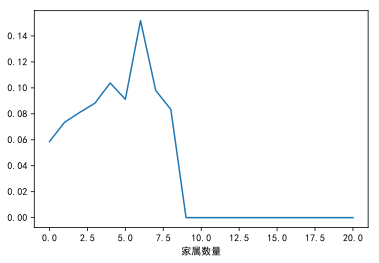

In [16]:
#绘制图形
bad_rate.plot()